In [1]:
import numpy as np
import healpy as hp

In [2]:
import matplotlib.pyplot as plt

In [3]:
def n2lm_index(n):
    """Input: one dimensional index of alm. Output: corresponding (l,m) index"""
    lt = (np.sqrt(8.0*n+1)-1.0)/2.0
    l = int(lt)
    m = int(n-l*(l+1)/2)
    return l,m

In [4]:
def lm2n_index(l,m):
    """Input: (l,m) index of the alm. Output: corresponding one dimensional index."""
    n = int(l*(l+1)/2 + m)
    return n

In [5]:
def mass_cl(ell, Cel = 1.0, Nel = 1.0):
    """Input: el & Cl, for l = 2 to elmax. Output: the mass for Cl parameters."""
    return 0.5*(2*ell+1)/(Cel+Nel)**2

In [6]:
def momentum_cl(m_cl, elmax):
    """Input: the mass of Cl, elmax. Output: the (elmax-1) length array of momentum for Cl."""
    return np.sqrt(m_cl)*np.random.normal(0.0, 1.0, elmax+1)

In [7]:
def mass_alm(Cl, Nl, elmax):
    """Input: Cl, elmax. Output: mass of real and imaginary part of alm"""
    """For the time being, assume data Cl is exact Cl"""
    m_almr = np.ndarray(shape = (n_alms))
    m_almi = np.ndarray(shape = (n_alms))
    m_almr.fill(1.0)
    m_almi.fill(1.0)
    #excluding alms for l = 0, and l = 1
    for i in np.arange(3, n_alms, 1):
        l,m = n2lm_index(i)
        if m == 0:
            #posterior variance of alm, when m = 0
            m_almr[i] = 1.0/Cl[l] + 1.0/Nl[l]
            m_almi[i] = 1.0
        else:
            #posterior variance of alm, when m != 0
            m_almr[i] = 2.0/Cl[l] + 2.0/Nl[l]
            m_almi[i] = 2.0/Cl[l] + 2.0/Nl[l]
    return m_almr, m_almi

In [8]:
def momentum_alm(m_almr, m_almi, n_alms):
    """Input: n_alms, m_almr, m_almi, 
    Output: momenum for real and imaginary part of alm"""
    p_almr = np.sqrt(m_almr)*np.random.normal(0, 1.0, n_alms)
    p_almi = np.sqrt(m_almi)*np.random.normal(0, 1.0, n_alms)
    return p_almr, p_almi

In [9]:
def pdot_alm(q_almr, q_almi, d_almr, d_almi, q_cl, Nl, n_alms):
    """Input:q_almr, q_almi, d_almr, d_almi, q_cl, Nl, n_alms. 
    Output: momentum derivative for real and imaginary part of alms- p_almr_dot & p_almi_dot."""
    p_almr_d = np.ndarray(shape = (n_alms))
    p_almi_d = np.ndarray(shape = (n_alms))
    p_almr_d.fill(0.0)
    p_almi_d.fill(0.0)
    for k in np.arange(3, n_alms, 1):
        l,m = n2lm_index(k)
        if m == 0:
            p_almr_d[k] = -1.0*q_almr[k]/q_cl[l] + (d_almr[k] - q_almr[k])/Nl[l]
            p_almi_d[k] = 0.0
        else:
            p_almr_d[k] = -2.0*q_almr[k]/q_cl[l] + 2.0*(d_almr[k] - q_almr[k])/Nl[l]
            p_almi_d[k] = -2.0*q_almi[k]/q_cl[l] + 2.0*(d_almi[k] - q_almi[k])/Nl[l]
    return p_almr_d, p_almi_d

In [10]:
def pdot_cl(el, Cl_hat, Cl):
    """Input: Cl_hat (Cl obtained using alms) and the Cl parameter. 
    Output: momentum derivative for Cl."""
    p_cl_d = np.ndarray(shape = (elmax+1))
    p_cl_d[0] = 0.0
    p_cl_d[1] = 0.0
    p_cl_d[2:] = 0.5*(2*el[2:]+1.0)*(Cl_hat[2:]/Cl[2:] - 1.0)/Cl[2:]
    return p_cl_d

In [11]:
#define the Hamiltonian
def KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms):
    """Computes the kinetic energy term of the Hamiltonian.
    Input: p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms.
    Output: Kinetic energy."""
    term1 = 0.5*np.sum(p_cl[2:]**2/m_cl[2:])
    term2 = 0.5*np.sum(p_almr[3:]**2/m_almr[3:])
    term3 = 0.0
    for k in np.arange(3, n_alms, 1):
        l,m = n2lm_index(k)
        if m != 0:
            term3 += p_almi[k]**2/m_almi[k]
    term3 = 0.5*term3
    KE = term1 + term2 + term3
    return KE

In [12]:
#define potential energy
def PE(Cl_hat, Dl_hat, Cl, Nl):
    """Computes the potential energy term of the Hamiltonian.
    Input: Cl_hat (Cl obtained using alms), 
           Dl_hat (Power spectrum of difference between data alms and sample alms)
           Cl, Nl.
    Output: Potential energy."""
    term1 = 0.5*np.sum((2.0*el[2:]+1.0)*Dl_hat[2:]/Nl[2:])
    term2 = 0.5*np.sum((2.0*el[2:]+1.0)*Cl_hat[2:]/Cl[2:])
    term3 = 0.5*np.sum((2.0*el[2:]+1.0)*np.log(Cl[2:]))
    PE = term1 + term2 + term3
    return PE

In [13]:
#compute Cl_hat
def Cl_of_almri(almr, almi, elmax):
    """Computes the Cl for the given alms (real and imaginary part separately)"""
    Cl_h = np.ndarray(shape = (elmax+1))
    Cl_h[0] = 0.0
    Cl_h[1] = 0.0
    for l in np.arange(2, elmax+1, 1):
        temp = 0.0
        k = lm2n_index(l,0)
        temp = almr[k]**2
        for m in np.arange(1, l + 1, 1):
            k = lm2n_index(l,m)
            temp += 2.0*(almr[k]**2 + almi[k]**2)
        Cl_h[l] = temp/(2.0*l + 1.0)
    return Cl_h

In [14]:
#mock angular power spectra
elmax = 16
nside = elmax
el = np.arange(0, elmax+1, 1)
Cl_th = np.ndarray(shape = (elmax+1))
#monopole and dipole = 0
Cl_th[0] = 0.0
Cl_th[1] = 0.0
#constant power spectrum
Cl_th[2:] = 3.0
#power law power spectrum
#Cl_th[2:] = 5.0/el[2:]**(0.1)

Text(0, 0.5, '$C_{\\ell}$')

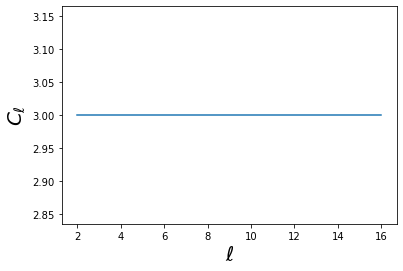

In [15]:
#plot angular power spectrum
plt.plot(el[2:], Cl_th[2:])
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)

In [16]:
#noise power spectra
Nl = np.ndarray(shape = (elmax+1))
#white noise power spectra
Nl.fill(0.01)
#monopole and dipole = 0
Nl[0] = 0.0
Nl[1] = 0.0

In [17]:
#generate a signal realization for the given Cl; real space map and its harmonic coefficients
map_sig, alm_sig = hp.synfast(cls = Cl_th, nside = nside, lmax=elmax, mmax=elmax, alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)

/home/shabbir/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/shabbir/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/shabbir/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [18]:
#compute realization angular power spectrum
map_Cl = hp.anafast(map_sig, lmax=elmax, mmax = elmax, alm=False, pol=False)

In [19]:
#generate a noise realization, map as well as alms
map_noise, alm_noise = hp.synfast(cls = Nl, nside = nside, lmax=elmax, mmax=elmax, alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)

In [20]:
#compute power spectra of noise realization
noise_Nl = hp.anafast(map_noise, lmax=elmax, mmax = elmax, alm=False, pol=False)

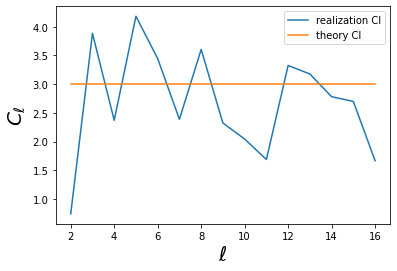

In [21]:
#compare theory and realization angular power spectrum
plt.plot(el[2:], map_Cl[2:], label = 'realization Cl')
plt.plot(el[2:], Cl_th[2:], label = 'theory Cl')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

In [22]:
#combine signal realisation and noise realization to get a 'data' realization
#in real space
map_data = map_sig + map_noise
#in harmonic space
alm_data = alm_sig + alm_noise

In [23]:
#compare signal and noise standard deviation
np.std(map_sig), np.std(map_noise)

(7.746110938010742, 0.49118429472297614)

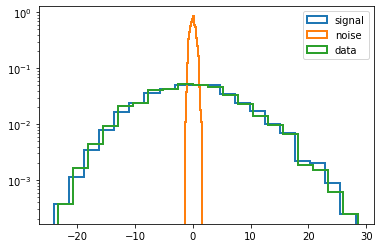

In [24]:
#compare data, signal and noise distribution
plt.hist(map_sig, histtype='step', bins=20, label = 'signal', density=True, lw = 2.0)
plt.hist(map_noise, histtype='step', bins=20, label = 'noise', density=True, lw = 2.0)
plt.hist(map_data, histtype='step', bins=20, label = 'data', density=True, lw = 2.0)
plt.legend(loc = 'upper right')
plt.yscale('log')

In [25]:
#compute data angular power spectrum
data_cl = hp.alm2cl( alms1 = alm_data, alms2=None, lmax=elmax, mmax=elmax, lmax_out=elmax,nspec=None)

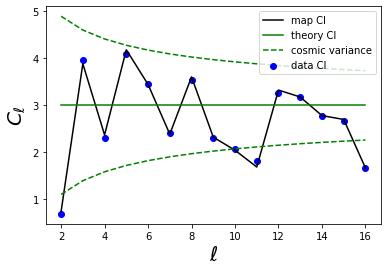

In [26]:
plt.scatter(el[2:], data_cl[2:], color = 'b', label = 'data Cl')
plt.plot(el[2:], map_Cl[2:], 'k', label = 'map Cl')
plt.plot(el[2:], Cl_th[2:], 'g', label = 'theory Cl')
plt.plot(el[2:], Cl_th[2:] + np.sqrt(2)*Cl_th[2:]/np.sqrt(2*el[2:]+1), color = 'g', 
         ls = '--', label = 'cosmic variance')
plt.plot(el[2:], Cl_th[2:] - np.sqrt(2)*Cl_th[2:]/np.sqrt(2*el[2:]+1), color = 'g', 
         ls = '--')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

In [27]:
#number of alms for given elmax
n_alms = int((elmax+1)*(elmax+2)/2)

In [28]:
#define required arrays
#alm position
q_almr = np.ndarray(shape = (n_alms))
q_almi = np.ndarray(shape = (n_alms))
p_almr = np.ndarray(shape = (n_alms))
p_almi = np.ndarray(shape = (n_alms))

In [29]:
#for alm velocity: alm momentum divided by alm mass
q_almr_dot = np.ndarray(shape = (n_alms))
q_almi_dot = np.ndarray(shape = (n_alms))
p_almr_dot = np.ndarray(shape = (n_alms))
p_almi_dot = np.ndarray(shape = (n_alms))

In [30]:
#for Cl
q_cl = np.ndarray(shape = (elmax+1))
p_cl = np.ndarray(shape = (elmax+1))
q_cl_dot = np.ndarray(shape = (elmax+1))
p_cl_dot = np.ndarray(shape = (elmax+1))

In [31]:
#data vector array
d_almr = np.ndarray(shape = (n_alms))
d_almi = np.ndarray(shape = (n_alms))

In [32]:
#auxiliary vaiable to arrange data alms in a desired order (first all m of given l, then next l)
dlm = np.ndarray(shape = (elmax+1, elmax+1), dtype = complex)

In [33]:
#first read the 1D indexed alms of healpy, arranged according to healpy convention
index = 0
for m in np.arange(0, elmax+1, 1):
    for l in np.arange(m, elmax+1, 1):
        dlm[l,m] = alm_data[index]
        index += 1

In [34]:
#read the alms in 1D index, according to 'first all m of given l, then next l'
index = 0
for i in np.arange(0, elmax+1, 1):
    for j in np.arange(0, i + 1, 1):
        d_almr[index] = np.real(dlm[i,j])
        d_almi[index] = np.imag(dlm[i,j])
        index += 1

In [35]:
#mass matrix for Cl
m_cl = np.ndarray(shape = (elmax+1))
m_cl.fill(1.0)
m_cl[2:] = mass_cl(el[2:], map_Cl[2:], noise_Nl[2:])

In [36]:
#mass matrix for alms
m_almr, m_almi = mass_alm(map_Cl, Nl, elmax) #use signal realization Cl
#m_almr, m_almi = mass_alm(Cl_th, Nl, elmax) #one can also use theory Cl

In [37]:
#HMC parameters
#stepsize
eps = 0.1
#number of leap frog steps
N_lf = 10
#number of samples to be computed
N_samples = 2000

In [38]:
#array to store the parameter samples
sample_q_almr = np.ndarray(shape = (N_samples, n_alms) )
sample_q_almi = np.ndarray(shape = (N_samples, n_alms) )
sample_q_cl = np.ndarray(shape = (N_samples, elmax + 1) )
#array to store samples of realization Cl [not a sampling parameter]
sample_hat_cl = np.ndarray(shape = (N_samples, elmax + 1) )
#momentum samples, helps with troubleshooting
#sample_p_almr = np.ndarray(shape = (N_samples, n_alms) )
#sample_p_almi = np.ndarray(shape = (N_samples, n_alms) )
sample_p_cl = np.ndarray(shape = (N_samples, elmax + 1) )

In [39]:
#Uniform random number between 0 and 1, needed to implement the Metropolis rule
Uniform_rand_num = np.random.uniform(0.0, 1.0, N_samples)

In [40]:
#arrays to store Hamiltonian/energy related variables, some for the help with troubleshooting
dH_array = np.ndarray(shape = (N_samples))
KE_array = np.ndarray(shape = (N_samples, 2))
PE_array = np.ndarray(shape = (N_samples, 2))
H0_array = np.ndarray(shape = (N_samples))
Hstar_array = np.ndarray(shape = (N_samples))
dH_array[0] = 0.0
H0_array[0] = 0.0
Hstar_array[0] = 0.0

In [41]:
#Preparation for HMC 

#Initialise the loop
q_cl = np.copy(map_Cl)
q_almr = np.copy(d_almr)
q_almi = np.copy(d_almi)

#just as a placeholder value
q_cl_star = np.copy(q_cl)
q_almr_star = np.copy(q_almr)
q_almi_star = np.copy(q_almi)

#Draw the momentum
p_almr, p_almi = momentum_alm(m_almr, m_almi, n_alms)
p_cl = momentum_cl(m_cl, elmax)

#Compute Hamiltonian for the starting point
####################
KE_term =  KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
Cl_hat = np.copy(map_Cl)

Dl_hat = Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax) #np.copy(noise_Nl)
PE_term = PE(Cl_hat, Dl_hat, Cl_th, Nl)
H_star = KE_term + PE_term

In [42]:
#initialise the chain
sample_q_almr[0,3:] = np.copy(q_almr[3:])
sample_q_almi[0,3:] = np.copy(q_almi[3:])
sample_q_cl[0,2:] = np.copy(q_cl[2:])

accept_count = 0

#HMC loop
for i in np.arange(1, N_samples, 1):
    #print(i)
    #Draw the momentum
    p_almr, p_almi = momentum_alm(m_almr, m_almi, n_alms)
    p_cl = momentum_cl(m_cl, elmax)
    if i == 1:
        sample_p_cl[0, 2:] = p_cl[2:]
    KE_term0 = KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
    
    Dl_hat = Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax)
    
    PE_term0 = PE(Cl_hat, Dl_hat, q_cl, Nl)
    KE_array[i, 0] = KE_term0
    PE_array[i, 0] = PE_term0
    H0 = KE_term0 + PE_term0
    H0_array[i] = H0
        
    for j in np.arange(0, N_lf, 1):
        
        #half position step
        q_cl_dot = p_cl/m_cl
        q_cl = q_cl + q_cl_dot*eps*0.5
        
        q_almr_dot = p_almr/m_almr
        q_almi_dot = p_almi/m_almi
        
        q_almr = q_almr + q_almr_dot*eps*0.5
        q_almi = q_almi + q_almi_dot*eps*0.5
        
        #momentum step
        #compute p_cl_dot
        Cl_hat = Cl_of_almri(q_almr, q_almi, elmax)
        p_cl_dot = pdot_cl(el, Cl_hat, q_cl)
        
        p_cl = p_cl + p_cl_dot*eps
        
        #compute p_almr_dot, p_almi_dot
        p_almr_dot, p_almi_dot = pdot_alm(q_almr, q_almi, d_almr, d_almi, q_cl, Nl, n_alms)
        
        p_almr = p_almr + p_almr_dot*eps
        p_almi = p_almi + p_almi_dot*eps
        
        #half position step
        q_cl_dot = p_cl/m_cl
        q_cl = q_cl + q_cl_dot*eps*0.5
        
        q_almr_dot = p_almr/m_almr
        q_almi_dot = p_almi/m_almi
        
        q_almr = q_almr + q_almr_dot*eps*0.5
        q_almi = q_almi + q_almi_dot*eps*0.5
            
    #Metropolis rule
    KE_term_star = KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
    Dl_hat = Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax)
    PE_term_star = PE(Cl_hat, Dl_hat, q_cl, Nl)
    
    KE_array[i, 1] = KE_term_star
    PE_array[i, 1] = PE_term_star
    
    H_star = KE_term_star + PE_term_star
    Hstar_array[i] = H_star
    dH_array[i] = H0 - H_star
    
    sample_hat_cl[i, 2:] = np.copy(Cl_hat[2:])
    
    if np.log(Uniform_rand_num[i]) < (H0 - H_star):
        #accept the proposed sample
        sample_q_almr[i,3:] = np.copy(q_almr[3:])
        sample_q_almi[i,3:] = np.copy(q_almi[3:])
        sample_q_cl[i,2:] = np.copy(q_cl[2:])
        #also store the Cl momentum
        sample_p_cl[i, 2:] = np.copy(p_cl[2:])
        H0 = H_star
        accept_count += 1
    else:
        #new sample equal to the previous accepted sample
        sample_q_cl[i,2:] = np.copy(sample_q_cl[i-1,2:])
        sample_q_almr[i,3:] = np.copy(sample_q_almr[i-1,3:])
        sample_q_almi[i,3:] = np.copy(sample_q_almi[i-1,3:])
        #also store the Cl momentum
        sample_p_cl[i, 2:] = np.copy(sample_p_cl[i-1, 2:])
        #reset the variables
        q_cl = np.copy(sample_q_cl[i-1,:])
        q_almr = np.copy(sample_q_almr[i-1,:])
        q_almi = np.copy(sample_q_almi[i-1,:])
    #sample_q_cl[i,2:] = np.copy(q_cl[2:])
print(accept_count)

<ipython-input-42-eb77da3fae1a>:30: RuntimeWarning: invalid value encountered in add
  q_cl = q_cl + q_cl_dot*eps*0.5


1887


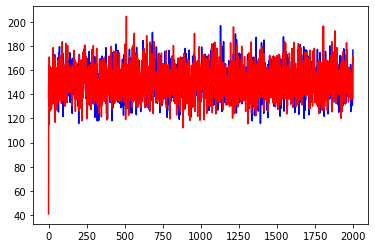

In [43]:
#plot kinetic energy before and after the leap frog steps
plt.plot(KE_array[1:, 0], 'b')
plt.plot(KE_array[1:, 1], 'r')

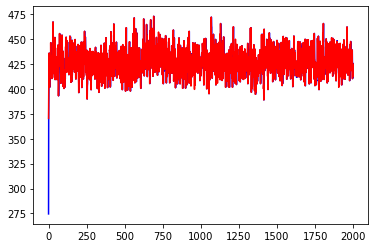

In [44]:
#plot potential energy before and after the leap frog steps
plt.plot(PE_array[1:, 0], 'b')
plt.plot(PE_array[1:, 1], 'r')

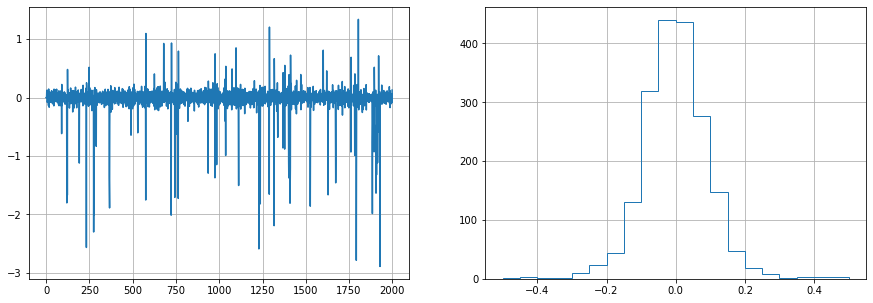

In [45]:
#check the change in hamiltonian
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(dH_array)
plt.grid()
plt.subplot(122)
plt.hist(dH_array, histtype='step', bins=20, range = [-0.5, 0.5])
plt.grid()

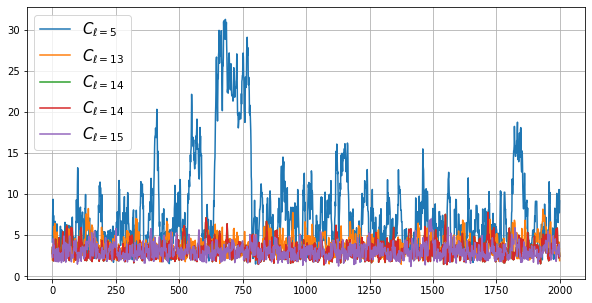

In [46]:
#check some Cl chains
index = np.random.uniform(2, 16, 5)
plt.figure(figsize = (10, 5))
for j in np.sort(index): #np.arange(2, index, 1):
    i = int(j)
    plt.plot(sample_q_cl[:,i], label = r'$C_{\ell = %d}$' %(i))
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

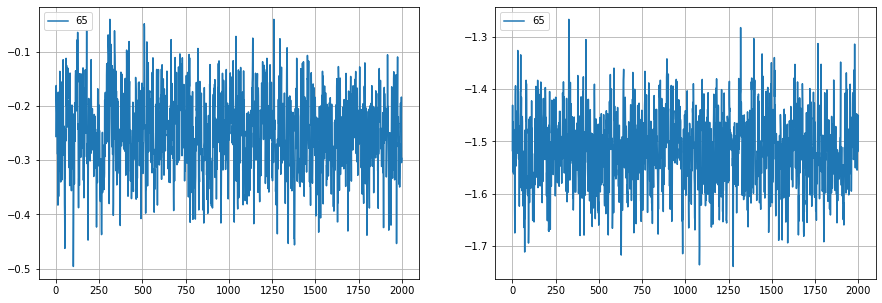

In [47]:
#inspect few chains of almr and almi
l = 10
m = 10
i = lm2n_index(l = l, m = m)
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(sample_q_almr[:,i], label = '%d' %(i))
plt.legend(loc = 'upper left')
plt.grid()
plt.subplot(122)
plt.plot(sample_q_almi[:,i], label = '%d' %(i))
plt.grid()
plt.legend(loc = 'upper left')

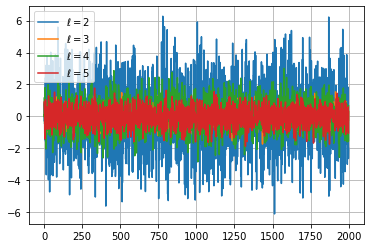

In [48]:
#inspect first few momentum chains of Cl
for i in np.arange(2, 5 + 1, 1):
    plt.plot(sample_p_cl[:,i], label = r'$\ell = %d$' %(i))
plt.legend(loc = 'upper left', fontsize = 10)
plt.grid()

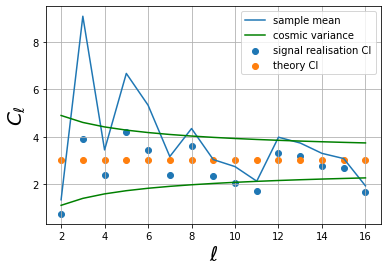

In [49]:
#plot the summary statistics
burnin = 1000
elmin = 2
plt.scatter(el[elmin:], map_Cl[elmin:], label = 'signal realisation Cl')
plt.scatter(el[elmin:], Cl_th[elmin:], label = 'theory Cl')
#plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:]*(2.0*el[elmin:]+1)/(2.0*el[elmin:]+2), axis=0) )
plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:], axis=0), label = 'sample mean')
plt.plot(el[elmin:], Cl_th[2:] + Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'g', label =  'cosmic variance')
plt.plot(el[elmin:], Cl_th[2:] - Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'g' )
plt.grid()
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

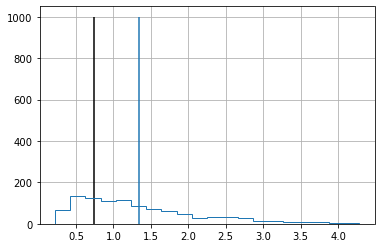

In [50]:
ell = 2
h = plt.hist(sample_q_cl[burnin:, ell], histtype='step', bins=20)
plt.vlines(np.mean(sample_q_cl[burnin:, ell], axis = 0), 0, 1000 )
plt.vlines(map_Cl[ell], 0, 1000, color = 'k' )
plt.grid()

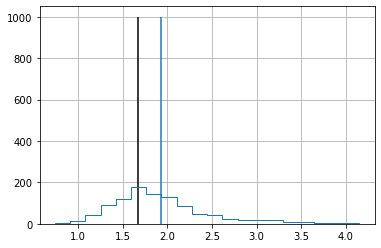

In [51]:
ell = 16
h = plt.hist(sample_q_cl[burnin:, ell], histtype='step', bins=20)
plt.vlines(np.mean(sample_q_cl[burnin:, ell], axis = 0), 0, 1000 )
plt.vlines(map_Cl[ell], 0, 1000, color = 'k' )
plt.grid()

In [52]:
#save the samples
np.savetxt("almr_chain.dat", sample_q_almr)
np.savetxt("almi_chain.dat", sample_q_almi)
np.savetxt("cl_chain.dat", sample_q_cl)